<a href="https://colab.research.google.com/github/aim56009/Bias_GAN/blob/master/data/run_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
#%cd "/content/gdrive/MyDrive/data_gan"

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/aim56009/Bias_GAN.git

Cloning into 'Bias_GAN'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 331 (delta 148), reused 194 (delta 124), pack-reused 99
Receiving objects: 100% (331/331), 79.81 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [3]:
%%capture
!pip install pytorch_lightning
!pip install basemap

In [4]:
!pip install importlib-metadata==4.0.1
!pip install xarray==0.18.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.2.0
    Uninstalling importlib-metadata-5.2.0:
      Successfully uninstalled importlib-metadata-5.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.1 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 4.0.1 which is incompatible.
gym 0.25.2 requires importlib-metadata>=4.8.0; python_version < "3.10", but you have importlib-metadata 4.0.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.3/807.3 KB 15.1 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2022.12

In [5]:
from argparse import ArgumentParser
import warnings
warnings.filterwarnings('ignore')
from dataclasses import dataclass, field
from typing import List
import getpass

#from Bias_GAN.code.src.trainer import train_cycle_gan

# Training

In [6]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import json

from Bias_GAN.code.src.model import CycleGAN
from Bias_GAN.code.src.data import DataModule
from Bias_GAN.code.src.utils import get_version, set_environment, get_checkpoint_path, save_config
from Bias_GAN.code.src.callbacks import get_cycle_gan_callbacks

In [7]:
def train_cycle_gan(config, pretrain_path=False):
    """ Main routing to train the Cycle GAN """
    
    config = Config()
    version = get_version()
    print(f'Running model: {version}')
    checkpoint_path = get_checkpoint_path(config, version)
    
    set_environment()
    print("checkpoint_path before:",checkpoint_path) 
    tb_logger = TensorBoardLogger(config.tensorboard_path,
                           name=config.model_name,
                           default_hp_metric=False,
                           version = checkpoint_path)
                           #version = version

    trainer = pl.Trainer(gpus = 1,
                         max_epochs = config.epochs,
                         precision = 16, 
                         #progress_bar_refresh_rate = config.progress_bar_refresh_rate,
                         callbacks = get_cycle_gan_callbacks(checkpoint_path),
                         num_sanity_val_steps = 1,
                         logger = tb_logger,
                         log_every_n_steps = config.log_every_n_steps,
                         deterministic = False,
                         accelerator=accelerator) 

    datamodule = DataModule(config, training_batch_size = config.train_batch_size,
                                    test_batch_size = config.test_batch_size)

    datamodule.setup("fit")

    
    
    if pretrain_path==False:
      print("no pretraining")
      model = CycleGAN(epoch_decay = config.epochs // 2,running_bias=config.running_bias)
    else:
      print("using pretrained model with path:",pretrain_path)
      model = CycleGAN(epoch_decay = config.epochs // 2,running_bias=config.running_bias).load_from_checkpoint(pretrain_path)

    trainer.fit(model, datamodule)

    save_config(config, version)
    print('Training finished')
    return model

# Config

In [8]:
@dataclass
class Config:
    """ 
    Training configuration parameters. For model evaluation parameters see
    src/configuration.py.
    """
    
    scratch_path: str = '/content/gdrive/MyDrive/bias_gan/results'
    tensorboard_path: str = f'{scratch_path}/'
    checkpoint_path: str = f'{scratch_path}/'
    config_path: str = f'{scratch_path}/'
    poem_path: str = f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_gfdl-esm4_historical_regionbox_1979-2014.nc"
    era5_path: str = f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_W5E5v2.0_regionbox_era5_1979-2014.nc"
   

    results_path: str = f'{scratch_path}/'
    projection_path: str = None

    train_start: int = 1979
    train_end: int = 1980 # set to 2000 for full run
    valid_start: int = 2004 #was 2001
    valid_end: int = 2004
    test_start: int = 2004
    test_end: int = 2014
    
    model_name: str = 'tibet_gan'

    epochs: int = 2 # set to 250 for reproduction
    progress_bar_refresh_rate: int = 1
    train_batch_size: int = 1
    test_batch_size: int = 64
    transforms: List = field(default_factory=lambda: ['log', 'normalize_minus1_to_plus1'])
    rescale: bool = False
    epsilon: float = 0.0001
    lazy: bool = False
    log_every_n_steps: int = 2 ### was 10
    norm_output: bool = True
    running_bias: bool = False


def main():
    _ = train_cycle_gan(Config())

# Run

In [ ]:
do_training = True


if do_training == True:
    accelerator="gpu"

    ###### for doing a new run ######
    train_cycle_gan(Config())

    ###### for running a pretrained checkpoint ######
    #train_cycle_gan(Config(),"/content/gdrive/MyDrive/bias_gan/results/2023_01_05_12h_30m_56s/last.ckpt")


# Inference

## inference

In [11]:
class Inference():

    """ Execute model on test data and return output as NetCDF. """
    
    def __init__(self,
                 config,
                 constrain=False,
                 projection=False,
                 projection_path=None,
                 max_num_inference_steps=None):
        

        self.config = config
        self.constrain = constrain
        self.results_path = config.results_path

        self.poem = xr.open_dataset(self.config.poem_path)
        self.era5 = xr.open_dataset(self.config.era5_path)

        self.train_start = str(config.train_start)
        self.train_end = str(config.train_end)
        self.test_start = str(config.test_start)
        self.test_end = str(config.test_end)
        self.epsilon = config.epsilon
        self.projection = projection
        self.projection_path = projection_path

        self.model = None
        self.model_output = None
        self.dataset = None

        self.transforms = config.transforms
        self.max_num_inference_steps = max_num_inference_steps
        self.tst_batch_sz = 64
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        
    def load_model(self, checkpoint_path):
    
        model = CycleGAN().load_from_checkpoint(checkpoint_path=checkpoint_path)
        model.freeze()
        self.model = model.to(self.device)
        self.model = ConstrainedGenerator(self.model.g_B2A, constrain=self.constrain)


    def get_model(self):
        return self.model 

        
    def get_dataloader(self):

        #datamodule = DataModule(self.config,
        #                        trn_batch_sz = 1,
        #                        tst_batch_sz = self.tst_batch_sz)
        datamodule = DataModule(self.config,
                                training_batch_size = 1,
                                test_batch_size = self.tst_batch_sz)
        if self.projection:
            print('running projection')
            datamodule.setup("predict")
        else:
            datamodule.setup("test")
        dataloader = datamodule.test_dataloader()

        return dataloader

    def get_projection_dataloader(self):

        dataloader = ProjectionDataset(self.config)
        return dataloader
    
        
    def compute(self):
        """ Use B (ESM) -> A (ERA5) generator for inference """

        test_data = self.get_dataloader()

        data = []

        print("Start inference:")
        for idx, sample in enumerate(test_data):
            sample = sample['B'].to(self.device)
            yhat = self.model(sample)

            data.append(yhat.squeeze().cpu())
            if self.max_num_inference_steps is not None:
                if idx > self.max_num_inference_steps - 1:
                    break
            
        self.model_output = torch.cat(data)


    def test(self):
        dataset = CycleDataset('test', self.config)
        test_data = dataset[0]
        sample = test_data['A'][0]
        data = self.inv_transform(sample)
        print(data.min(), data.max())

    
    def get_netcdf_result(self):
        
        time = self.poem.sel(time=slice(self.test_start, self.test_end)).time

        if self.projection:
            time = xr.open_dataset(self.projection_path).time

        if self.max_num_inference_steps is not None:
            time = time.isel(time=slice(0, (self.max_num_inference_steps+1)*self.tst_batch_sz))

        latitude = self.poem.latitude
        longitude = self.poem.longitude
        
        gan_data= xr.DataArray(
            data=self.model_output,
            dims=["time", "latitude", "longitude"],
            coords=dict(
                time=time,
                latitude=latitude,
                longitude=longitude,
            ),
            attrs=dict(
                description="gan_precipitation",
                units="mm/s",
            ))
        
        gan_dataset = gan_data.to_dataset(name="gan_precipitation")
        self.gan_dataset = gan_dataset.transpose('time', 'latitude', 'longitude')

        return self.gan_dataset


    def inv_transform(self, data, reference=None):
        """ The output equals ERA5, therefore it needs to be
            constraind with respect to it
        """
        if reference is None:
            reference = self.era5.era5_precipitation.sel(time=slice(self.train_start, self.train_end)).values

        if 'log' in self.transforms:
            reference = log_transform(reference, self.epsilon)

        if 'normalize' in self.transforms:
            data = inv_norm_transform(data, reference)

        if 'normalize_minus1_to_plus1' in self.transforms:
            data = inv_norm_minus1_to_plus1_transform(data, reference)

        if 'log' in self.transforms:
            data = inv_log_transform(data, self.epsilon)

        return data

    
    def write(self, fname):
        
        ds = self.get_netcdf_result()
        path  = self.results_path + fname
        ds.to_netcdf(path)


## evaluate checkpoints fct

In [12]:
def create_folder(path):
    from pathlib import Path
    Path(path).mkdir(parents=True, exist_ok=True)

In [13]:
class EvaluateCheckpoints():
    """ 
        Interate over model checkpoints and
        show the test set results.
    """
    
    def __init__(self,
                 checkpoint_path,
                 config_path,
                 plot_summary=False,
                 show_plots=False,
                 save_model=True,
                 constrain=False,
                 epoch_index=None,
                 projection=False,
                 max_num_inference_steps=None,
                 projection_path=None
                 ):

        self.checkpoint_path = checkpoint_path
        print(f'loading checkpoints from directory: {self.checkpoint_path}')
        #self.config_path = "/data/checkpoint_folder/config_model_f9ffc4a0-7ae1-11ed-b373-fd94a6d70968.json" #Config.config_path #'/results/'#Config.config_path
        self.config_path = config_path
        self.reports_path = f'{Config.results_path}reports/'
        self.projection_path = projection_path
        self.projection = projection
        self.plot_summary = plot_summary
        self.uuid = None
        self.show_plots = show_plots
        self.gan_results = None
        self.save_model = save_model
        self.model_fname = 'gan.nc'
        self.model = None
        self.test_data = None
        self.constrain = constrain
        self.epoch_index = epoch_index
        self.max_num_inference_steps = max_num_inference_steps


    def load_config(self):
        path = self.config_path
            #print("path print",config_from_file)
        #self.uuid = self.get_uuid_from_path(path)
            #print("self.uuid print",self.uuid)
        #config = config_from_file(f'{self.config_path}config_model_{self.uuid}.json')
        config = config_from_file(path)
            #print("config print",print)
        if self.projection_path is not None:
            config.projection_path = self.projection_path
        return config



    def get_uuid_from_path(self, path: str):
        import re
        print("path in get_uuid", path)
        uuid4hex = re.compile('[0-9a-f]{8}-[0-9a-f]{4}-[1-5][0-9a-f]{3}-[89ab][0-9a-f]{3}-[0-9a-f]{12}', re.I)
        print("uuid4hex",uuid4hex)
        print("uuid4hex search path",uuid4hex.search(path))
        uuid = uuid4hex.search(path).group(0)
        return uuid


    def run(self):         ############## maybe add checkpoint_path as variable ##############
        
        self.config = self.load_config()
        #files = self.get_files(self.checkpoint_path)
        #if self.epoch_index is not None:
        #    files = [files[self.epoch_index-1]]
        
        files = [self.checkpoint_path]
        for i, fname in enumerate(files):
            self.checkpoint_idx = i+1
            self.num_checkpoints = len(files)
            print(f'Checkpoint {self.checkpoint_idx} / {self.num_checkpoints}:')
            print(fname)
            print('')
            self.run_inference(fname)
            self.read_test_data()
            self.get_plots()
            
        return self.get_test_data()
        
        
    def get_files(self, path: str):
        
        if os.path.isfile(path):
            files = []
            files.append(path) 
        else:
            files = os.listdir(path)
            for i, f in enumerate(files):
                files[i] = os.path.join(path, f) 
        return files

    def run_inference(self, path: str):
        
        inf = Inference(self.config,
                        constrain=self.constrain,
                        projection=self.projection,
                        projection_path=self.projection_path,
                        max_num_inference_steps=self.max_num_inference_steps)
        inf.load_model(path)
        inf.compute()
        self.gan_results = inf.get_netcdf_result()
        self.model = inf.get_model()
        if self.save_model:
            inf.write(self.model_fname)
    
        
    def read_test_data(self):
    
        climate_model = xr.open_dataset(self.config.poem_path)
        if 'poem_precipitation' in climate_model.variables:
            climate_model =  climate_model.poem_precipitation
        else:
            climate_model =  climate_model.precipitation
        era5 = xr.open_dataset(self.config.era5_path).era5_precipitation
        gan = self.gan_results.gan_precipitation

        data = TestData(era5, gan, climate_model=climate_model)
        data.convert_units()
        data.crop_test_period()
        data.show_mean()
        data.uuid = self.uuid
        data.model = self.model
        
        self.test_data = data


    def get_test_data(self):
        return self.test_data


    def show_reports(self, uuid):
        path = f'{self.reports_path}{uuid}/'
        files = self.get_files(path)
        for file in files:
            fig = Image(filename=file)
            display(fig)
        
        
    def get_plots(self):

        if self.plot_summary:
            plot = PlotAnalysis(self.test_data)
            new_dir = f'{self.reports_path}{self.uuid}/'
            create_folder(new_dir)
            fname = f'{new_dir}model_{self.uuid}_number_{self.checkpoint_idx}.png'
            plot.summary(plot_idx=self.checkpoint_idx, 
                         num_plots=self.num_checkpoints,
                         fname=fname, show_plots=self.show_plots)

# eval

## eval imports

In [18]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from Bias_GAN.code.src.utils import show_checkpoints

import os
import xarray as xr
import torch
#from tqdm import tqdm
from IPython.display import Image, display

from Bias_GAN.code.src.model import  DataModule, ConstrainedGenerator
from Bias_GAN.code.src.data import TestData, CycleDataset, ProjectionDataset,  load_cmip6_model, CMIP6Data
from Bias_GAN.code.src.plots import PlotAnalysis
from Bias_GAN.code.src.utils import log_transform, inv_norm_transform, inv_log_transform, inv_norm_minus1_to_plus1_transform, norm_minus1_to_plus1_transform, config_from_file
#from Bias_GAN.code.main import Config
#from Bias_GAN.code.src.quantile_mapping import QuantileMapping
from Bias_GAN.code.src.projection_utils import ProjectionPreparation
from Bias_GAN.code.src.xarray_utils import write_dataset

## define plot functions

In [155]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

class PlotAnalysis():
    
    def __init__(self, data: TestData):
        
        self.data = data

        #self.names = ['era5', 'poem', 'gan']
        self.names = ['era5', 'gan', 'poem']
                 #self.names = ['era5', 'poem', 'cmip_model',   \
                 #'quantile_mapping', 'gan_constrained']

    def single_frames(self, vmin=0,
                              vmax=20,
                              time_index=-1,
                              cmap='Blues',
                              mask=False,
                              single_plot=False,
                              projection="robin"):
        fig, axs = plt.subplots(1, 3, figsize=(12,7),  constrained_layout=True)
        alpha = 1.0 
        name = ['era5','gan', 'climate_model']
        letters = ['a', 'b', 'c']

        for ax, (name, letter) in zip(axs, zip(name, letters)):
            data = abs(getattr(self.data, name).isel(time=time_index))
            if name == 'era5':
                print(data.time.values)

            ax.annotate(f"{letter}", ha="center", va="center", size=15,
                        xy=(1-0.955, 0.925), xycoords=ax,
                        bbox=None) 
            ax.set_title(self.data.model_name_definition(name))
            plt.title(self.data.model_name_definition(name))

            cbar = False
            cbar_title = ''

            cs = plot_basemap(data, cbar_title, vmin, vmax, alpha, cmap,
                        cbar=cbar,
                        axis=ax,
                        return_cs=True,
                        projection=projection,
                        map_resolution='c',
                        plot_mask=mask)
                 
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
        sm.set_array([])

        cbar = fig.colorbar(sm,
                     ax=axs,
                     location='bottom',
                     shrink=0.4,
                     aspect=10,
                     extend='max'
                     ).set_label('Precipitation [mm/d]', fontsize=13)

def plot_basemap(data: xr.DataArray,
                cbar_title: str,
                vmin: float,
                vmax: float,
                alpha: float,
                cmap: str,
                cbar=True,
                cbar_extend='max',
                cbar_position='right',
                return_cs=False,
                axis=None,
                plot_mask=False,
                draw_coordinates=False,
                parallel_label=[1, 0, 0, 0],
                meridian_label=[0, 0, 0, 1],
                contours=None,
                fig=None,
                projection='mill',
                contourf=False,
                map_resolution='l',
                vmin_contours=0.15,
                vmax_contours=0.40,
                mask_threshold=1):

    import matplotlib.pyplot as plt
    
    if axis is not None:
        cbar_plt = plt
        plt = axis

    lats = data.latitude
    lons = data.longitude

    if projection == 'mill':
        lon_0 = 0
    else:
        lon_0 = -180 

    m = Basemap(llcrnrlon=lons[0], llcrnrlat=lats[0],
                urcrnrlon=lons[-1], urcrnrlat=lats[-1],
                projection=projection, lon_0=lon_0, 
                resolution=map_resolution, ax=axis)

    m.drawcoastlines(color='k', linewidth=0.5)
                    
    if draw_coordinates:
        par = m.drawparallels(
                              [-90, -60, 0, 60, 90],
                              #[-90, -45, 0, 45, 90],
                              linewidth=1.0,
                              labels=parallel_label,
                              color='grey')

        merid = m.drawmeridians(
                                [ -90, 0, 90, 180],
                                #[-120, -60, 0, 60, 120, 180],
                                linewidth=1.0,
                                labels=meridian_label,
                                color='grey')
    
    Lon, Lat = np.meshgrid(lons, lats)
    
    x, y = m(Lon, Lat)
                    
    if contourf:
        cs = plt.contourf(x, y, data, 500, vmin=vmin, vmax=vmax,
                        alpha=alpha, cmap=cmap,
                        linewidth=0, shading='auto', extend='max')
    else:
        cs = plt.pcolormesh(x, y, data, vmin=vmin, vmax=vmax,
                        alpha=alpha, cmap=cmap,
                        linewidth=0, shading='auto')

    if plot_mask is True:
        mask = np.ma.masked_where(data > mask_threshold, data)
        plt.pcolormesh(x,y, mask, vmin=-1, vmax=-1, alpha=1.0, cmap='Greys',shading='auto')

    if contours is not None:
        cs2 = plt.contour(x, y, abs(contours), 8, 
                            alpha=1.0, cmap='YlOrRd',
                            linewidth=4.0, shading='auto')
    if axis is None:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(cbar_position, size="1.5%", pad=0.4)
        cbar_plt = cax
    if cbar:

        if axis is not None:
            ax = cbar_plt.gca()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes(cbar_position, size="2.5%", pad=0.2)
            cbar = cbar_plt.colorbar(cs, cax=cax,  label=cbar_title, extend=cbar_extend)
        else:
            cbar = plt.colorbar(cs, cax=cax,  label=cbar_title, extend=cbar_extend)

        cbar.solids.set(alpha=1)
        if cbar_position == 'left':
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')

        if contours is not None:
            norm = matplotlib.colors.Normalize(vmin=cs2.cvalues.min(), vmax=cs2.cvalues.max())
            sm = plt.cm.ScalarMappable(norm=norm, cmap = cs2.cmap)
            sm.set_array([])

            #cax = divider.new_vertical(size="3%", pad=0.2, pack_start=True)
            cax = divider.append_axes('right', size="1.5%", pad=0.2)
            #fig.add_axes(cax)
            fig.colorbar(sm,
                         ticks=cs2.levels,
                         cax=cax,
                         #orientation="horizontal",
                         orientation="vertical",
                         extend='max',
                         label='Feature importance [a.u.]')

    else:
        #cax = divider.append_axes("right", size="2%", pad=0.15)
        if axis is None:
            cax.set_visible(False)
    if return_cs:
        return cs

## eval running


In [73]:
checkpoint_path = "/content/gdrive/MyDrive/bias_gan/results/2023_01_09_07h_46m_22s/last.ckpt" 
config_path = "/content/gdrive/MyDrive/bias_gan/results/2023_01_09_07h_46m_22s/config_model.json"

data = EvaluateCheckpoints(checkpoint_path=checkpoint_path, config_path=config_path, save_model=False)

loading checkpoints from directory: /content/gdrive/MyDrive/bias_gan/results/2023_01_09_07h_46m_22s/last.ckpt


In [ ]:
data.run()

In [80]:
test_data = data.get_test_data()

2004-01-11T00:00:00.000000000
2004-01-11T00:00:00.000000000


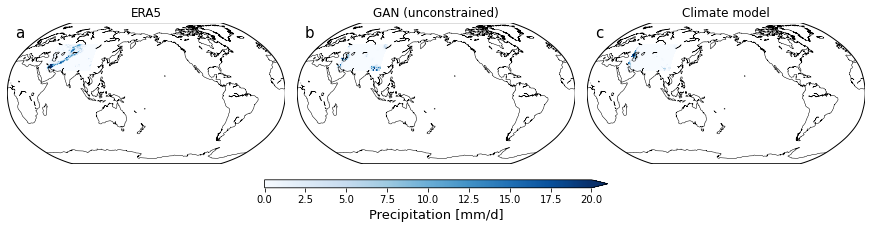

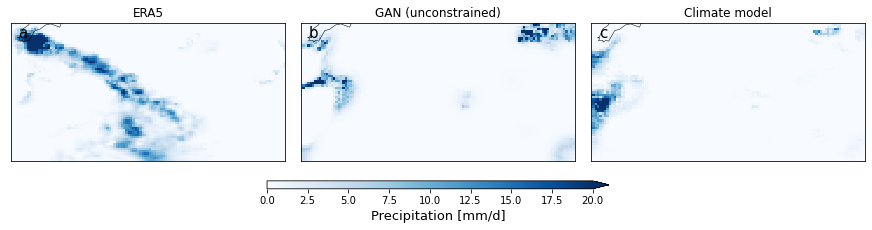

In [163]:
time_index=10

PlotAnalysis(test_data).single_frames(time_index=time_index)
PlotAnalysis(test_data).single_frames(projection="cyl",time_index=time_index)